Shape: (1325, 6)
Date range: 2020-10-13 00:00:00 ~ 2026-01-12 00:00:00
Columns: ['Date', 'dlog_SOLVPN', 'dlog_COPPER', 'dlog_DXY', 'd_UST10Y', 'dlog_VIX']

=== Missing counts ===
dlog_SOLVPN    0
dlog_COPPER    0
dlog_DXY       0
d_UST10Y       0
dlog_VIX       0
dtype: int64

=== Dtypes ===
Date           datetime64[ns]
dlog_SOLVPN           float64
dlog_COPPER           float64
dlog_DXY              float64
d_UST10Y              float64
dlog_VIX              float64
dtype: object

Saved: ./eda_out\desc_stats.csv

=== Outlier counts (|z|>5) ===
dlog_VIX       6
dlog_COPPER    3
dlog_SOLVPN    1
dlog_DXY       0
d_UST10Y       0
dtype: int64
Saved: ./eda_out\outlier_rows_z_gt_5.csv

Saved: ./eda_out\corr.csv


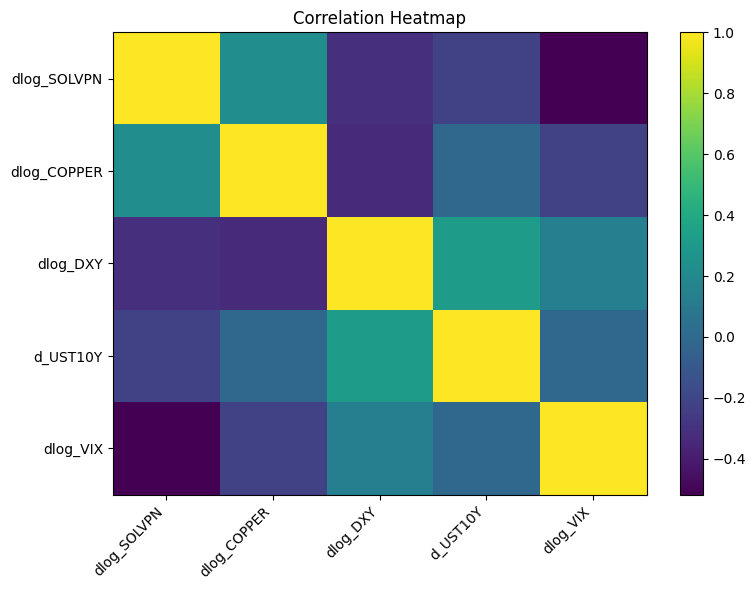

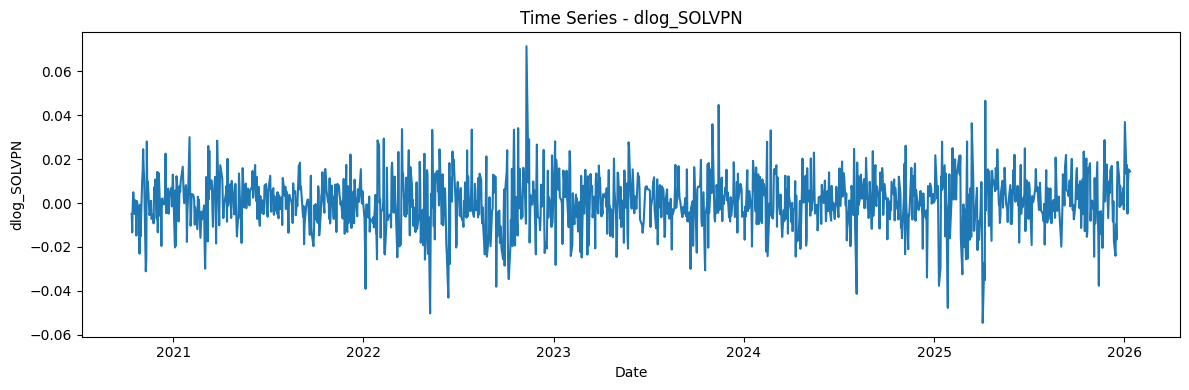

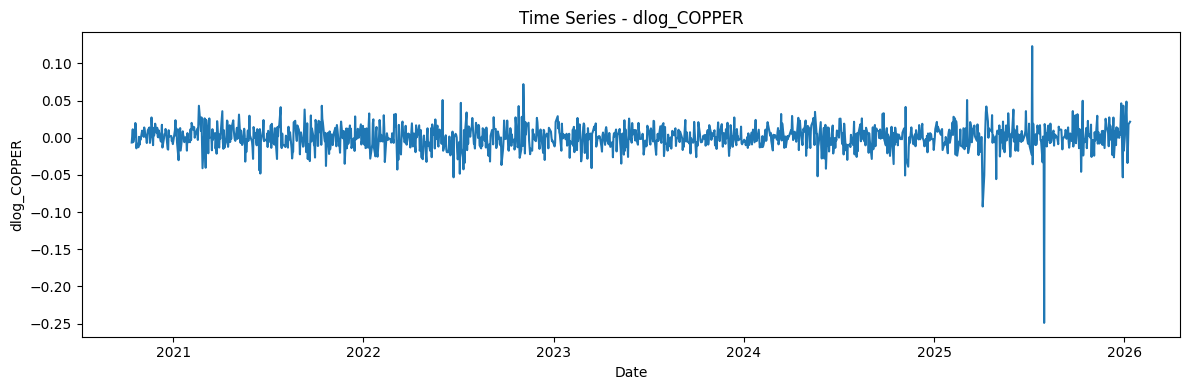

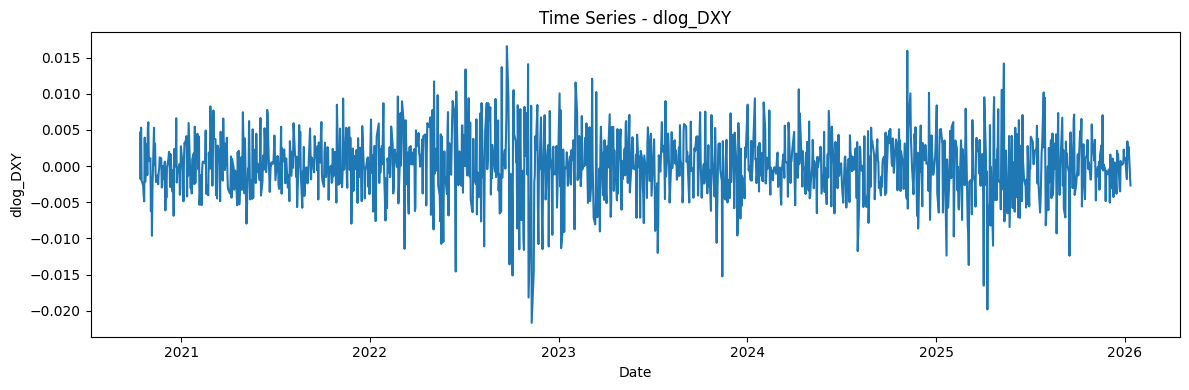

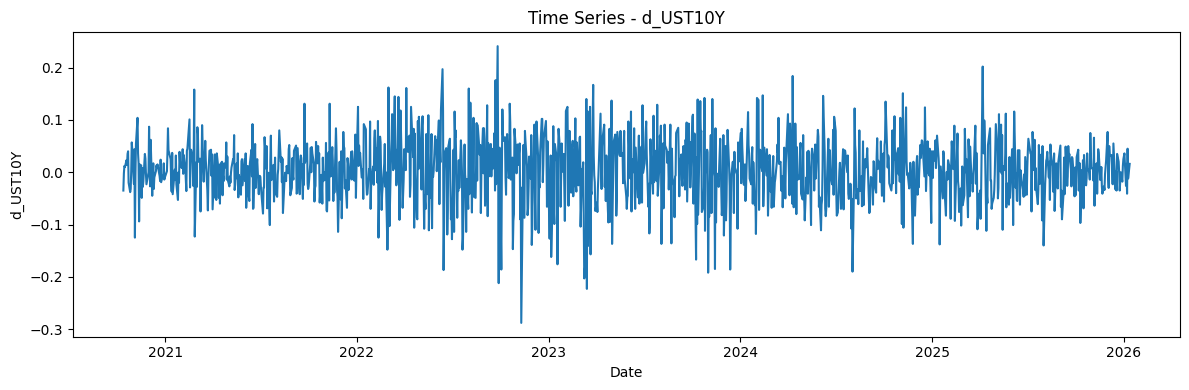

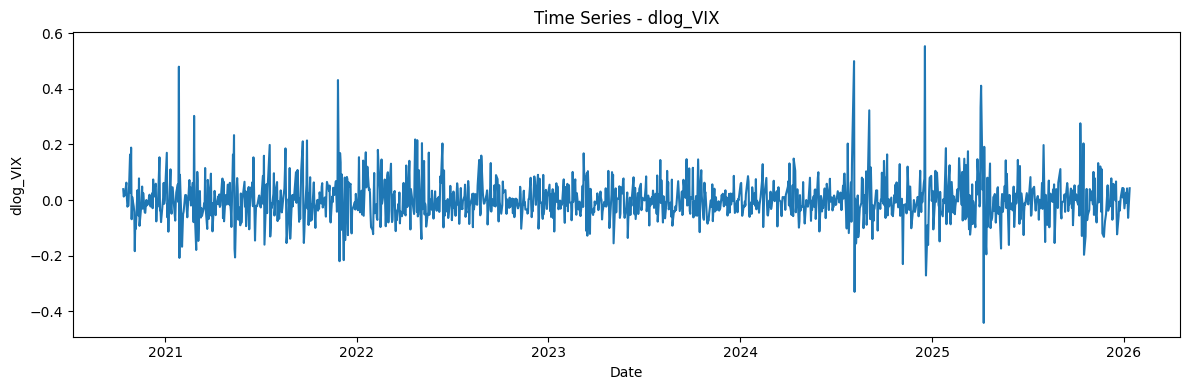

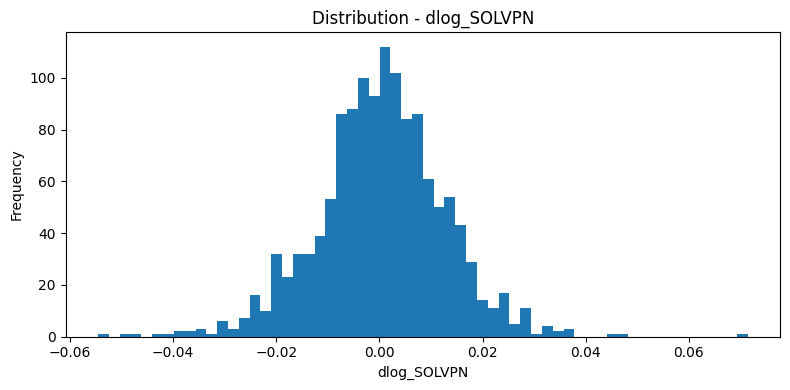

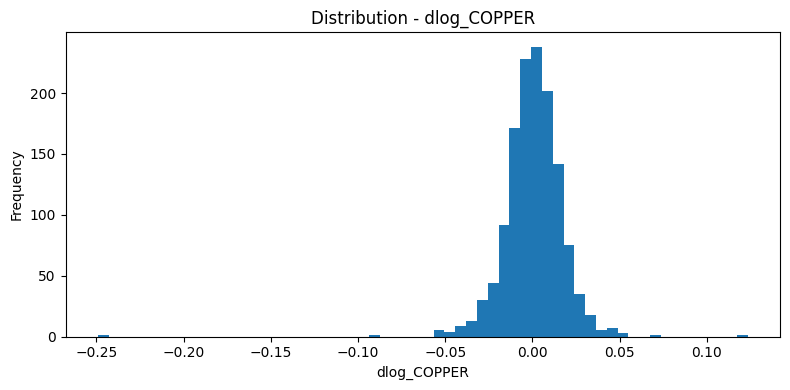

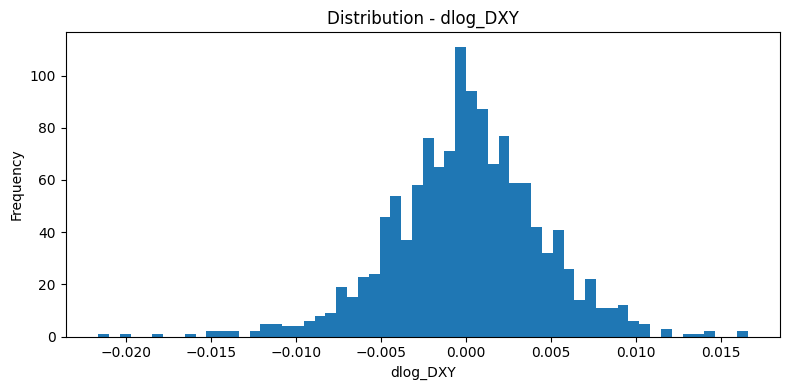

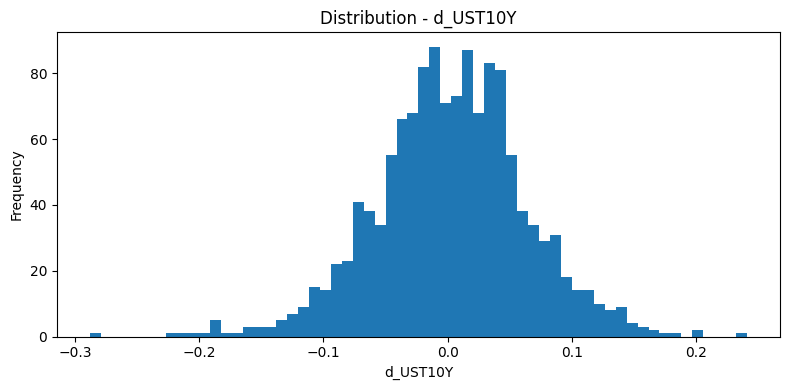

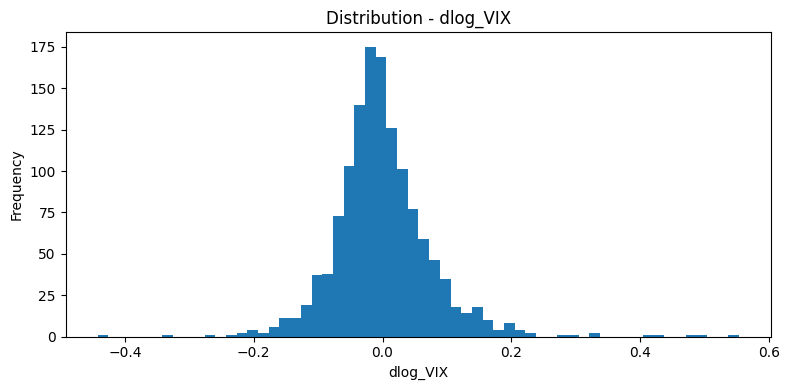

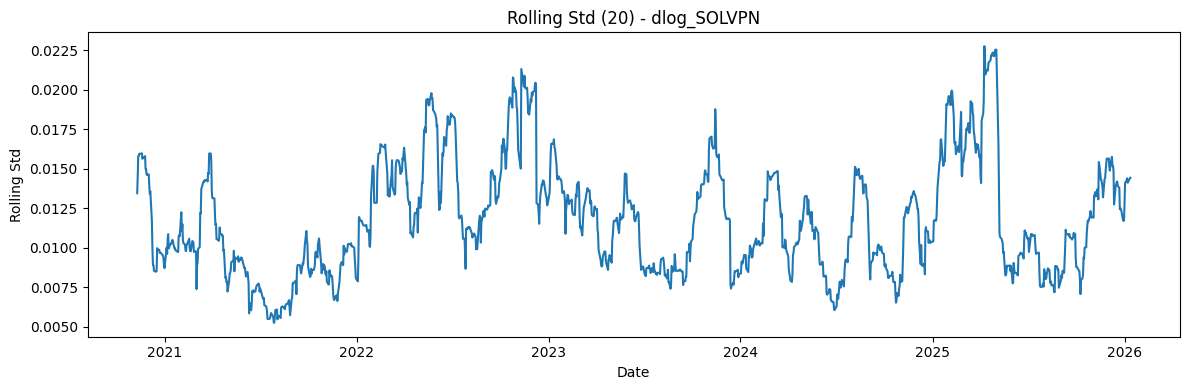

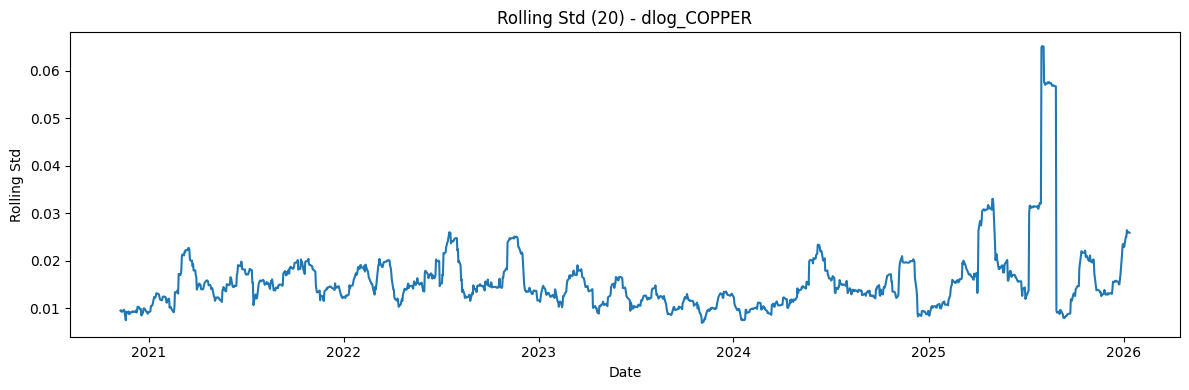

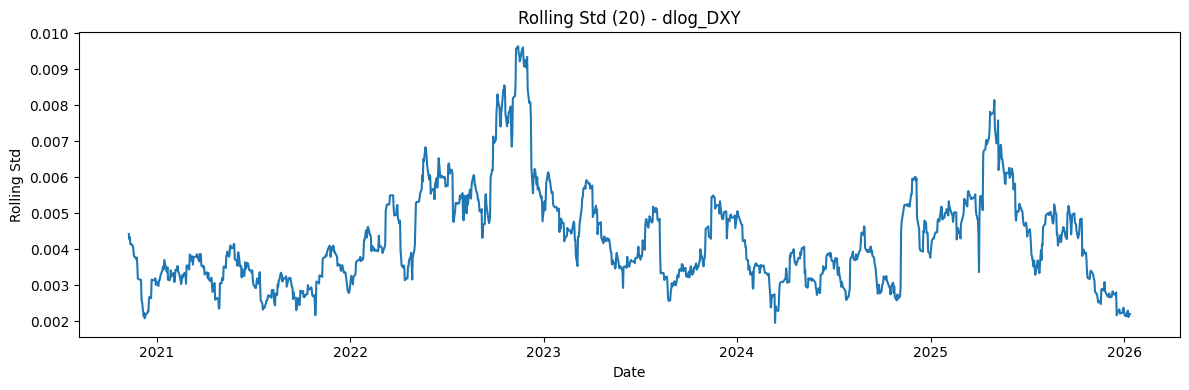

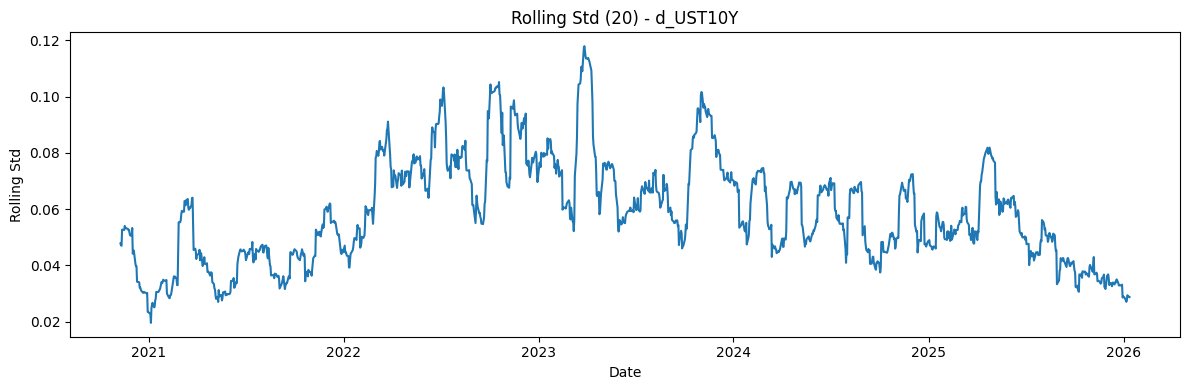

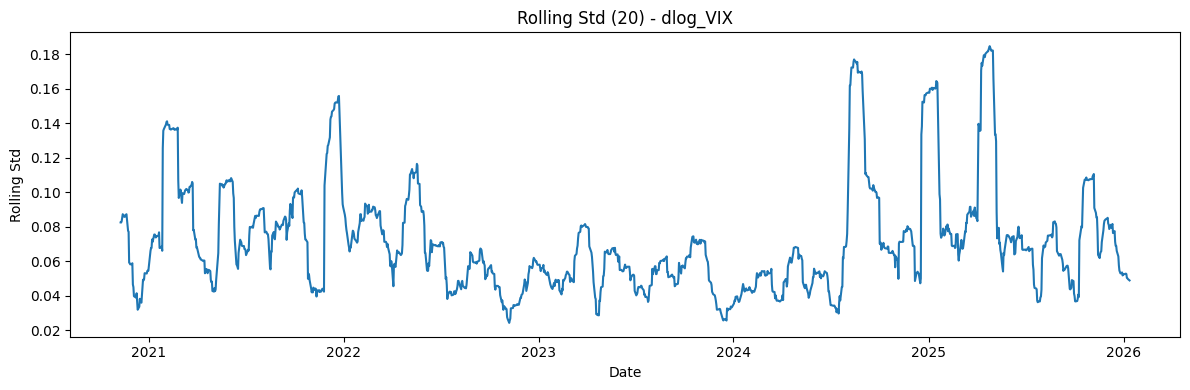

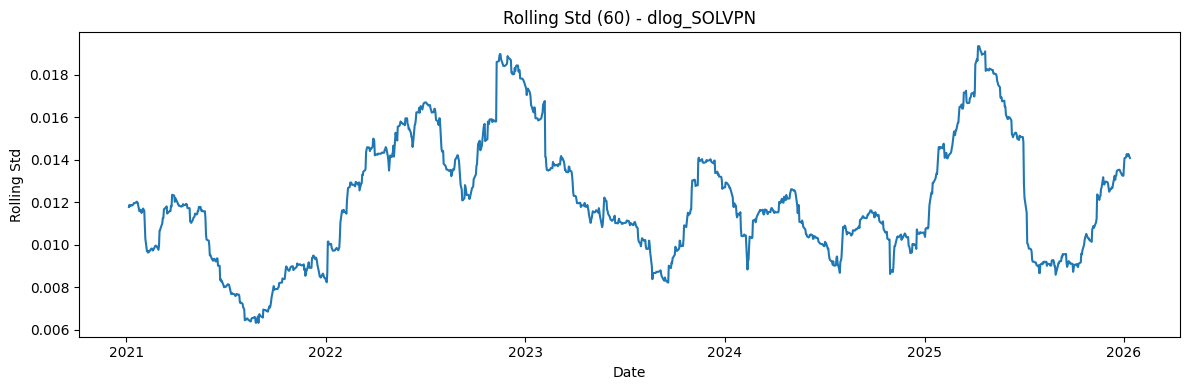

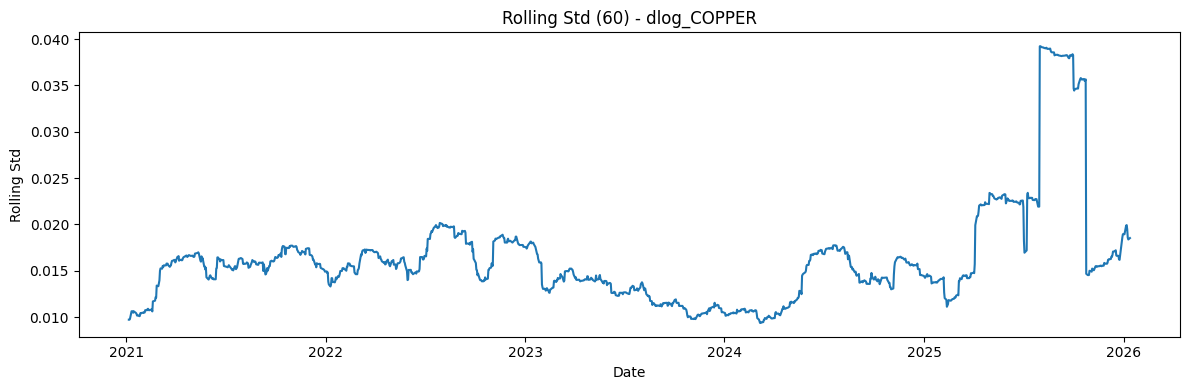

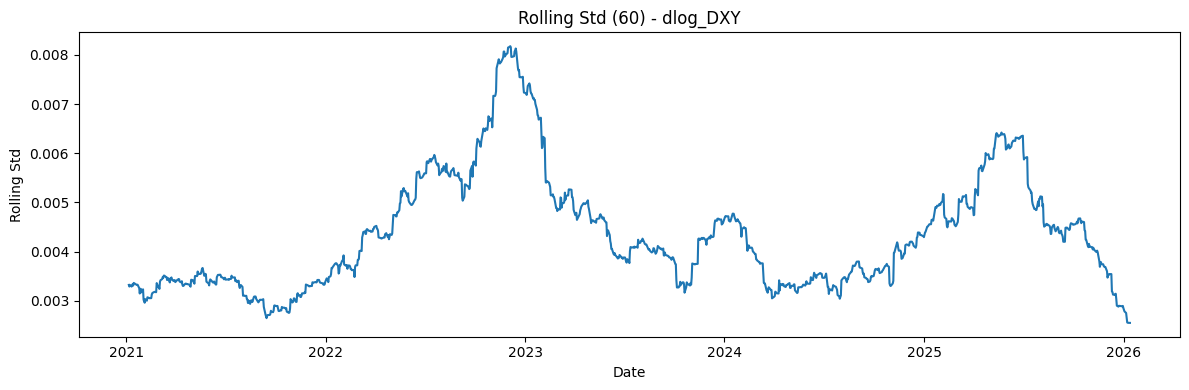

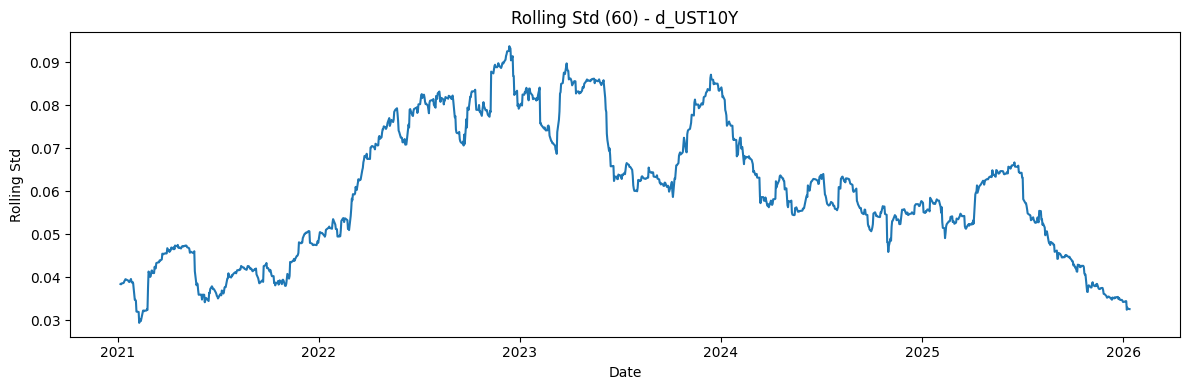

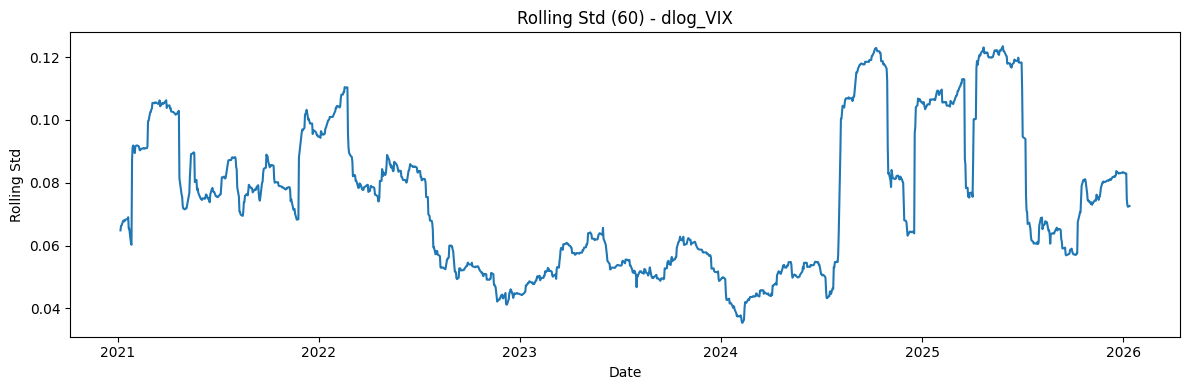

TypeError: stem() got an unexpected keyword argument 'use_line_collection'

<Figure size 1000x400 with 0 Axes>

In [1]:
# ============================================================
# EDA Starter Kit for VAR Spillover Data
# File: ./only_var_input.csv
# Output (optional): ./eda_out/
# - Basic stats, missing, outliers
# - Correlation heatmap (matplotlib)
# - Time series
# - Distributions
# - Rolling volatility
# - ACF / PACF
# - ADF stationarity test
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, acf, pacf

# ----------------------------
# 0) Config
# ----------------------------
DATA_PATH = "./only_var_input.csv"
OUT_DIR = "./eda_out"
os.makedirs(OUT_DIR, exist_ok=True)

ROLLING_WINDOWS = [20, 60]   # trading days
ACF_LAGS = 40
PACF_LAGS = 40
ADF_AUTOLAG = "AIC"

# ----------------------------
# 1) Load
# ----------------------------
df = pd.read_csv(DATA_PATH)
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

num_cols = [c for c in df.columns if c != "Date"]

print("Shape:", df.shape)
print("Date range:", df["Date"].min(), "~", df["Date"].max())
print("Columns:", df.columns.tolist())

# ----------------------------
# 2) Basic checks
# ----------------------------
# Missing
miss = df[num_cols].isna().sum().sort_values(ascending=False)
print("\n=== Missing counts ===")
print(miss)

# Dtypes
print("\n=== Dtypes ===")
print(df.dtypes)

# Descriptive stats
desc = df[num_cols].describe().T
desc["skew"] = df[num_cols].skew()
desc["kurtosis"] = df[num_cols].kurtosis()
desc.to_csv(os.path.join(OUT_DIR, "desc_stats.csv"))
print("\nSaved:", os.path.join(OUT_DIR, "desc_stats.csv"))

# Outlier quick view (|z|>5)
z = (df[num_cols] - df[num_cols].mean()) / df[num_cols].std(ddof=0)
outlier_counts = (z.abs() > 5).sum().sort_values(ascending=False)
print("\n=== Outlier counts (|z|>5) ===")
print(outlier_counts)

# Save outlier rows
outlier_any = (z.abs() > 5).any(axis=1)
df.loc[outlier_any, ["Date"] + num_cols].to_csv(os.path.join(OUT_DIR, "outlier_rows_z_gt_5.csv"), index=False)
print("Saved:", os.path.join(OUT_DIR, "outlier_rows_z_gt_5.csv"))

# ----------------------------
# 3) Correlation matrix + heatmap
# ----------------------------
corr = df[num_cols].corr()
corr.to_csv(os.path.join(OUT_DIR, "corr.csv"))
print("\nSaved:", os.path.join(OUT_DIR, "corr.csv"))

plt.figure(figsize=(8, 6))
plt.imshow(corr.values, aspect="auto")
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Correlation Heatmap")
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "corr_heatmap.png"), dpi=200)
plt.show()

# ----------------------------
# 4) Time series plots (one variable per figure)
# ----------------------------
for col in num_cols:
    plt.figure(figsize=(12, 4))
    plt.plot(df["Date"], df[col])
    plt.title(f"Time Series - {col}")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"ts__{col}.png"), dpi=200)
    plt.show()

# ----------------------------
# 5) Distribution plots (hist only)
# ----------------------------
for col in num_cols:
    plt.figure(figsize=(8, 4))
    plt.hist(df[col].dropna(), bins=60)
    plt.title(f"Distribution - {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"hist__{col}.png"), dpi=200)
    plt.show()

# ----------------------------
# 6) Rolling volatility plots
# ----------------------------
for w in ROLLING_WINDOWS:
    for col in num_cols:
        rv = df[col].rolling(w).std()
        plt.figure(figsize=(12, 4))
        plt.plot(df["Date"], rv)
        plt.title(f"Rolling Std ({w}) - {col}")
        plt.xlabel("Date")
        plt.ylabel("Rolling Std")
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f"rollstd{w}__{col}.png"), dpi=200)
        plt.show()

# ----------------------------
# 7) ACF / PACF (per variable)
# ----------------------------
def stem_plot(vals, title, out_path):
    x = np.arange(len(vals))
    plt.figure(figsize=(10, 4))
    plt.stem(x, vals, use_line_collection=True)
    plt.title(title)
    plt.xlabel("Lag")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.show()

for col in num_cols:
    x = df[col].dropna().values

    acf_vals = acf(x, nlags=ACF_LAGS, fft=True)
    pacf_vals = pacf(x, nlags=PACF_LAGS, method="ywm")

    stem_plot(acf_vals, f"ACF - {col}", os.path.join(OUT_DIR, f"acf__{col}.png"))
    stem_plot(pacf_vals, f"PACF - {col}", os.path.join(OUT_DIR, f"pacf__{col}.png"))

# ----------------------------
# 8) ADF test (stationarity)
# ----------------------------
adf_rows = []
for col in num_cols:
    x = df[col].dropna().values
    res = adfuller(x, autolag=ADF_AUTOLAG)
    adf_rows.append({
        "col": col,
        "adf_stat": res[0],
        "pvalue": res[1],
        "used_lag": res[2],
        "nobs": res[3]
    })

adf_df = pd.DataFrame(adf_rows).sort_values("pvalue")
adf_df.to_csv(os.path.join(OUT_DIR, "adf_results.csv"), index=False)
print("\nSaved:", os.path.join(OUT_DIR, "adf_results.csv"))
print(adf_df)

print("\nEDA finished. Outputs in:", OUT_DIR)
